# 1. Extract Multi-instance images from COCO

### 1.1 3x3 grid image with annotations

In [2]:
from PIL import Image
import os
from pycocotools.coco import COCO
import json


# Loads an image, resizes it to 256x256, scales its bounding boxes, and saves the resized image. Returns the updated annotations.
def save_image(img_info, anns,img_dir, output_dir):
    img_path = os.path.normpath(os.path.join(img_dir, img_info['file_name'])) # get the image path, normalizing the path to handle mixed separators
    # print("img_path = ",img_path)
    os.makedirs(output_dir, exist_ok=True)
    # print("output_dir = ",save_dir)


    # Check if the file exists before opening
    if not os.path.exists(img_path):
        print(f"Skipping {img_path} - File not found.")
        return  

    # load the image
    img = Image.open(img_path)

    # cal the scaling factor for width and height, for cal BB later 
    width, height = img.size
    scale_w = 256 / width
    scale_h = 256 / height

    # resize the image to 256*256
    img = img.resize((256, 256))
    img_info['width'] = 256
    img_info['height'] = 256

    save_path = os.path.join(output_dir, img_info['file_name'])
    img.save(save_path)


    # resize the BB according to the scaling factor
    new_anns = []
    for ann in anns:
        # get the BB
        x, y, w, h = ann['bbox']

        # scale the BB
        x *= scale_w
        y *= scale_h
        w *= scale_w
        h *= scale_h
        # update the BB
        ann['bbox'] = [x, y, w, h]
        ann['area'] = w*h

        new_anns.append(ann)

    return new_anns



def update_annotation_file(new_images, updated_anns, original_ann_file):
    # Load the original annotation file to retrieve the categories information
    with open(original_ann_file, 'r') as f:
        original_data = json.load(f)
    
    # Update the images and annotations fields
    original_data['images'] = new_images
    original_data['annotations'] = updated_anns
    
    # Write the updated data back to the original file
    with open(original_ann_file, 'w') as f:
        json.dump(original_data, f)



def extract_images(cat_names, img_dir, output_dir , original_ann_file):
    ## Requirements:
    # 1. Contains at least one foreground object. A foreground object must be from one of the 
    # three categories: [ ’pizza’, ’cat’, ’bus’].

    # 2. Additionally, the area of any foreground object must be larger than 200×200 = 40000 pixels. 
    # There can be multiple foreground objects in an image since we are dealing with multi-instance 
    # object localization for this homework. If there is none, that image should be discarded.

    # 3. When saving your images to disk, resize them to 256×256. Note that you would also need to 
    # scale the bounding box parameters accordingly after resizing

    cat_ids = coco.getCatIds(catNms=cat_names)

    # get all image IDs containing the above categories
    img_ids = coco.getImgIds(catIds=cat_ids)

    min_area = 40000  # 200x200


    # List to store valid images
    valid_images = []
    target_category = ["pizza", "cat", "bus"]
    updated_anns_total = []

    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0] # get image info to save the data later

        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)

        # anns includes bounding box, category ID, and segmentation, area, imageID!!!!!!!!!!!!!!!!
        anns = coco.loadAnns(ann_ids)

        # Filter annotations: keep only those whose category is in foreground_categories 
        # and whose area is larger than min_area.
        valid_anns = []

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']
            
            # if this object category is in target_category and area is larger than min_area
            if obj_category in target_category and ann['area'] > min_area:
                valid_anns.append(ann)
        
        
        # print(f"Found {len(valid_images)} images with valid annotations.") ## 3957 for training, 2062 for validation.

        # If at least one valid annotation exists, save the image and update the annotations
        if valid_anns:
            new_anns = save_image(img_info, valid_anns, img_dir, output_dir) 

            if new_anns:
                valid_images.append(img_info)
                updated_anns_total.extend(new_anns)

    return valid_images, updated_anns_total




# Set COCO dataset paths
# data_dir = os.getcwd()

#  mac users
# ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
# image_dir = os.path.join(data_dir, "train2014/train2014")  

# windows users
ann_file_train = "./../data/annotations/instances_train2014.json"
image_dir_train = "./../HW6/train2014/train2014" 
image_dir_val = "./val2014/val2014"

ann_file_val = "./../data/annotations/instances_val2014.json"
output_dir_train = "./../data/Multi-instance_images_from_COCO(HW7)/train"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW7)/val"



# Ensure output directories exist
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)


all_new_images = []
all_updated_anns = []


# Load COCO dataset
coco = COCO(ann_file_train)

valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_train)


# Load COCO dataset
coco = COCO(ann_file_val)

valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_val)


loading annotations into memory...
Done (t=10.54s)
creating index...
index created!
loading annotations into memory...
Done (t=4.74s)
creating index...
index created!


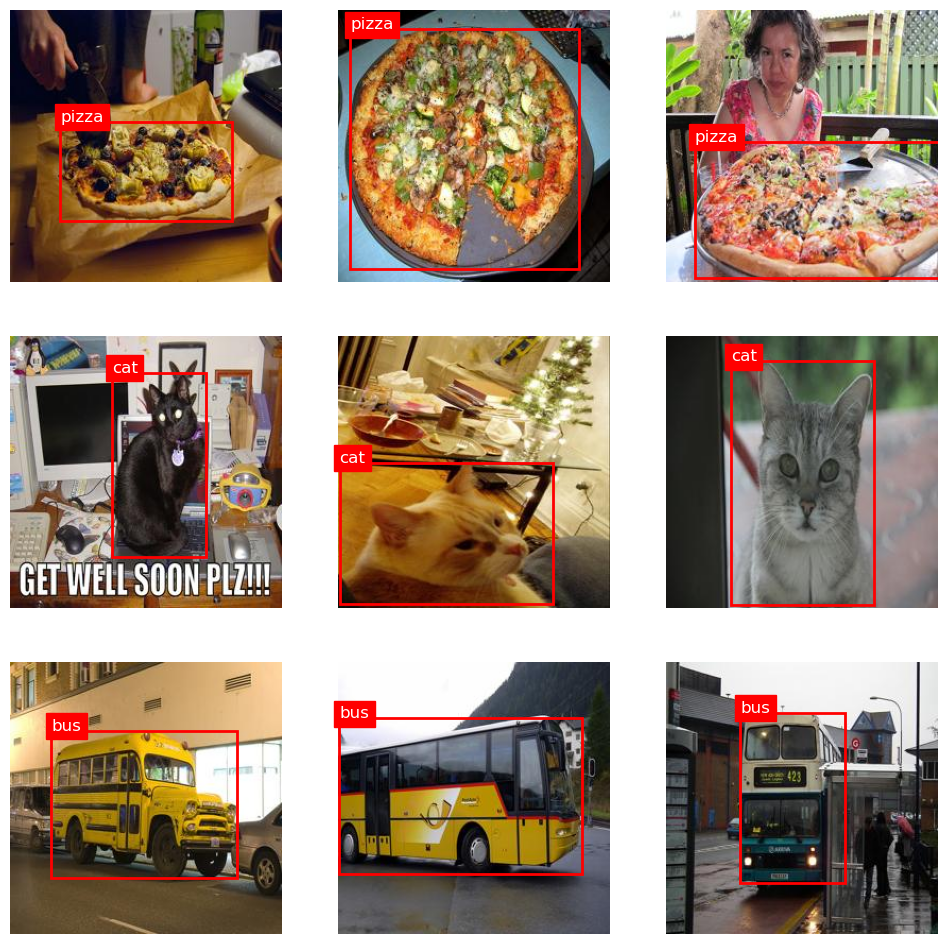

In [14]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_images(annotation_file, image_dir):
    # Load the updated annotation file 
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    # Build mappings for images and catID2name
    images = {img["id"]: img for img in data["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}
    # print("images\n",images) ## {466949: {'license': 1, 'file_name': 'COCO_train2014_000000466949.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000466949.jpg', 'height': ....
    # print("cat_id_to_name\n",cat_id_to_name) ## {1: 'person', 2: 'bicycle', 3: 'car'...

    
    target_categories = ["pizza", "cat", "bus"]
    # get their ID
    cat_to_img_ids = {cat: set() for cat in target_categories} # set for avoiding duplicate ## cat_to_img_ids = {'pizza': set(), 'cat': set(), 'bus': set()}
    for ann in data["annotations"]:
        cat_name = cat_id_to_name[ann["category_id"]]
        if cat_name in target_categories:
            cat_to_img_ids[cat_name].add(ann["image_id"])
    
    # Select 3 images per category 
    selected_ids = []
    for cat in target_categories:
        count = 0
        # print("\n\n",cat)
        for img_id in cat_to_img_ids[cat]:
            # print("check",img_id)
            if img_id not in selected_ids:
                selected_ids.append(img_id)
                # print("add",img_id)
                count += 1
            if count == 3:
                break

    # print(selected_ids)
 

    # plot the 3x3 graph
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flatten()
    for i, img_id in enumerate(selected_ids):
        img_info = images[img_id]
        img_path = os.path.join(image_dir, img_info["file_name"])
        
        # Open the image using PIL
        img = Image.open(img_path)

        axs[i].imshow(img)
        axs[i].axis("off")
        
        # For each annotation in the image, add a rectangle patch and label it with the category name
        for ann in data["annotations"]:
            if ann["image_id"] == img_id:
                bbox = ann["bbox"] # Format: [x, y, width, height]

                # Create a rectangle patch for the bounding box
                rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
                axs[i].add_patch(rect)

                # Add the category name label at the top-left corner of the bounding box
                cat_name = cat_id_to_name[ann["category_id"]]
                axs[i].text(bbox[0], bbox[1], cat_name,fontsize=12, color='white', backgroundcolor='red')
        
    plt.show()



updated_annotation_file = "./../data/annotations/instances_train2014.json"
resized_image_dir = "./../data/Multi-instance_images_from_COCO(HW7)/train"

visualize_images(updated_annotation_file, resized_image_dir)


# this is copy from yolologic, i want to chnage the dataloader to meet the COCO format. Use the rest of the code of yoloogic for training


In [ ]:
import os
import json
import pickle
import glob
import numpy as np
from PIL import Image

def convert_json_to_pickle(json_file, image_dir, output_p_file, max_objects=5, img_size=(256,256)):
    """
    Convert COCO-like JSON annotations to a pickle file with the format expected by PurdueDrEvalMultiDataset.
    
    Each image's annotation will be a dictionary with:
      - 'filename': the image file name (or you can set None if not needed)
      - 'num_objects': number of object instances (up to max_objects)
      - 'bboxes': a dict mapping index 0..max_objects-1 to a bbox tuple (x1, y1, x2, y2) or None
      - 'bbox_labels': a dict mapping index 0..max_objects-1 to a label string (e.g., "category_3") or None
      - 'seg_masks': a dict mapping index 0..max_objects-1 to a segmentation mask (dummy PIL image in mode '1') or None
    """
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Build a mapping from image id to image info (file name, etc.)
    img_id_to_info = {img['id']: img for img in data['images']}
    
    # Build a mapping from image id to a list of its annotations
    img_id_to_anns = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_id_to_anns:
            img_id_to_anns[img_id] = []
        img_id_to_anns[img_id].append(ann)
    
    # Create the final annotations dict (keys: image file paths, values: annotation dict)
    all_annotations = {}
    
    for img_id, img_info in img_id_to_info.items():
        file_name = img_info['file_name']
        image_path = os.path.join(image_dir, file_name)
        anns = img_id_to_anns.get(img_id, [])
        
        # Sort annotations if needed (for reproducibility)
        anns = sorted(anns, key=lambda x: x.get('id', 0))
        
        annotation_dict = {}
        annotation_dict['filename'] = file_name
        num_objects = min(len(anns), max_objects)
        annotation_dict['num_objects'] = num_objects
        
        bboxes = {}
        bbox_labels = {}
        seg_masks = {}
        
        # Process each annotation up to max_objects
        for i in range(max_objects):
            if i < num_objects:
                ann = anns[i]
                # Convert bbox from [x, y, width, height] to (x1, y1, x2, y2)
                x, y, w, h = ann['bbox']
                bbox = (int(x), int(y), int(x+w), int(y+h))
                bboxes[i] = bbox
                # Convert category_id to a label string (modify mapping as needed)
                bbox_labels[i] = f"category_{ann['category_id']}"
                # Create a dummy segmentation mask (all zeros, mode "1")
                seg_masks[i] = Image.new('1', img_size)
            else:
                bboxes[i] = None
                bbox_labels[i] = None
                seg_masks[i] = None
        
        annotation_dict['bboxes'] = bboxes
        annotation_dict['bbox_labels'] = bbox_labels
        annotation_dict['seg_masks'] = seg_masks
        
        # Use the file name as the key (or image_path if you prefer)
        all_annotations[file_name] = annotation_dict
    
    # Save the dictionary to a pickle file
    with open(output_p_file, 'wb') as f:
        pickle.dump(all_annotations, f)
    
    print(f"Converted JSON annotations for {len(all_annotations)} images and saved to {output_p_file}")



convert_json_to_pickle('./../data/annotations/instances_train2014.json', './../data/Multi-instance_images_from_COCO(HW7)/train', './../data/Multi-instance_images_from_COCO(HW7)/train/annotations.p')
convert_json_to_pickle('./../data/annotations/instances_val2014.json', './../data/Multi-instance_images_from_COCO(HW7)/val', './../data/Multi-instance_images_from_COCO(HW7)/val/annotations.p')


Converted JSON annotations for 6010 images and saved to ./../data/Multi-instance_images_from_COCO(HW7)/val/annotations.p


In [ ]:
import os, sys, torch, torchvision
import torch.nn as nn


print(os.getcwd())
sys.path.append("./../YOLOLogic-2.1.4")

from YOLOLogic import YOLOLogic

class MyYOLOLogic(YOLOLogic):
    # This inherits all the properties and method from YOLOLogic

    def __init__(self, *args, **kwargs ):
        # call the parent class init with keyword arguments
        super(MyYOLOLogic, self).__init__(**kwargs)

    class MyYoloObjectDetector(nn.Module):             
        def __init__(self, yolomod):                                 ## 'yolomod' stands for 'yolo module'
            super(YOLOLogic.YoloObjectDetector, self).__init__()
            self.yolomod = yolomod
            self.train_dataloader = None
            self.test_dataloader = None

        def show_sample_images_from_dataset(self, yolo):
            data = next(iter(self.train_dataloader))    
            real_batch = data[0]
            first_im = real_batch[0]
            self.yolomod.display_tensor_as_image(torchvision.utils.make_grid(real_batch, padding=2, pad_value=1, normalize=True))

        def set_dataloaders(self, train=False, test=False):
            if train:
                dataserver_train = MyYOLOLogic.MyDataset(self.yolomod, 
                                                    "train", dataroot_train=self.yolomod.dataroot_train)
                self.train_dataloader = torch.utils.data.DataLoader(dataserver_train, 
                                                    self.yolomod.batch_size, shuffle=True, num_workers=4)
            if test:
                dataserver_test = MyYOLOLogic.MyDataset(self.yolomod, 
                                                        "test", dataroot_test=self.yolomod.dataroot_test)
                ## In the statement below, 1 is for the batch_size for testing
                self.test_dataloader = torch.utils.data.DataLoader(dataserver_test, 1, shuffle=False)

        def check_dataloader(self, how_many_batches_to_show, train=False, test=False):
            if train:      
                dataloader = self.train_dataloader
            if test:
                dataloader = self.test_dataloader
            for idx, data in enumerate(dataloader): 
                if idx >= how_many_batches_to_show:  
                    break
                im_tensor, seg_mask_tensor, bbox_tensor, bbox_label_tensor, num_objects_in_image = data
                print("\n\nNumber of objects in the batch images: ", num_objects_in_image)
                print("\n\nlabels for the objects found:")
                print(bbox_label_tensor)

                mask_shape = seg_mask_tensor.shape
                logger = logging.getLogger()
                old_level = logger.level
                logger.setLevel(100)
                #  Let's now display the batch images:
                plt.figure(figsize=[15,4])
                plt.imshow(np.transpose(torchvision.utils.make_grid(im_tensor, normalize=True,
                                                                        padding=3, pad_value=255).cpu(), (1,2,0)))
                plt.show()
                #  Let's now display the batch with JUST the masks:
                composite_mask_tensor = torch.zeros(im_tensor.shape[0], 1,128,128)
                for bdx in range(im_tensor.shape[0]):
                    for i in range(num_objects_in_image[bdx]):
                        composite_mask_tensor[bdx] += seg_mask_tensor[bdx][i]
                plt.figure(figsize=[15,4])
                plt.imshow(np.transpose(torchvision.utils.make_grid(composite_mask_tensor, normalize=True,
                                                                        padding=3, pad_value=255).cpu(), (1,2,0)))
                plt.show()
                #  Let's now display the batch and masks in a side-by-side display:
                display_image_and_mask_tensor = torch.zeros(2*im_tensor.shape[0], 3,128,128)
                display_image_and_mask_tensor[:im_tensor.shape[0],:,:,:]  = im_tensor
                display_image_and_mask_tensor[im_tensor.shape[0]:,:,:,:]  = composite_mask_tensor
                plt.figure(figsize=[15,4])
                plt.imshow(np.transpose(torchvision.utils.make_grid(display_image_and_mask_tensor, normalize=False,
                                                                        padding=3, pad_value=255).cpu(), (1,2,0)))
                plt.show()
                #  Let's now display the batch with GT bboxes for the objects:
                im_with_bbox_tensor = torch.clone(im_tensor)
                for bdx in range(im_tensor.shape[0]):
                    bboxes_for_image = bbox_tensor[bdx]
                    for i in range(num_objects_in_image[bdx]):
                        ii = bbox_tensor[bdx][i][0].item()
                        ji = bbox_tensor[bdx][i][1].item()
                        ki = bbox_tensor[bdx][i][2].item()
                        li = bbox_tensor[bdx][i][3].item()
                        im_with_bbox_tensor[bdx,:,ji,ii:ki] = 255    
                        im_with_bbox_tensor[bdx,:,li,ii:ki] = 255                
                        im_with_bbox_tensor[bdx,:,ji:li,ii] = 255  
                        im_with_bbox_tensor[bdx,:,ji:li,ki] = 255  
                plt.figure(figsize=[15,4])
                plt.imshow(np.transpose(torchvision.utils.make_grid(im_with_bbox_tensor, normalize=False,
                                                                        padding=3, pad_value=255).cpu(), (1,2,0)))
                plt.show()
                #  Let's now display the batch with GT bboxes and the object labels
                im_with_bbox_tensor = torch.clone(im_tensor)
                for bdx in range(im_tensor.shape[0]):
                    labels_for_image = bbox_label_tensor[bdx]
                    bboxes_for_image = bbox_tensor[bdx]
                    for i in range(num_objects_in_image[bdx]):
                        ii = bbox_tensor[bdx][i][0].item()
                        ji = bbox_tensor[bdx][i][1].item()
                        ki = bbox_tensor[bdx][i][2].item()
                        li = bbox_tensor[bdx][i][3].item()
                        im_with_bbox_tensor[bdx,:,ji,ii:ki] = 40    
                        im_with_bbox_tensor[bdx,:,li,ii:ki] = 40                
                        im_with_bbox_tensor[bdx,:,ji:li,ii] = 40  
                        im_with_bbox_tensor[bdx,:,ji:li,ki] = 40  
                        im_pil = tvt.ToPILImage()(im_with_bbox_tensor[bdx]).convert('RGBA')
                        text = Image.new('RGBA', im_pil.size, (255,255,255,0))
                        draw = ImageDraw.Draw(text)
                        horiz = ki-10 if ki>10 else ki
                        vert = li
                        label = self.yolomod.class_labels[labels_for_image[i]]
                        label = "wtower" if label == "watertower" else label
                        label = "Dr Eval" if label == "Dr_Eval" else label
                        draw.text( (horiz,vert), label, fill=(255,255,255,200) )
                        im_pil = Image.alpha_composite(im_pil, text)
                        im_with_bbox_tensor[bdx] = tvt.ToTensor()(im_pil.convert('RGB'))

                plt.figure(figsize=[15,4])
                plt.imshow(np.transpose(torchvision.utils.make_grid(im_with_bbox_tensor, normalize=False,
                                                                        padding=3, pad_value=255).cpu(), (1,2,0)))
                plt.show()
                logger.setLevel(old_level)



    class MyDataset(torch.utils.data.Dataset):
        """
        New dataset that loads annotations from a .p file (converted from JSON)
        and returns output in the same format as PurdueDrEvalMultiDataset:
        (im_tensor, seg_mask_tensor, bbox_tensor, bbox_label_tensor, num_objects)
        """
        def __init__(self, yolo, train_or_test, dataroot, transform=None, max_objects=5):
            """
            Args:
                yolo: an instance of YOLOLogic or similar that provides class_labels.
                train_or_test: 'train' or 'test'
                dataroot: path to the folder containing the 'annotations.p' file and an 'images' subfolder.
                transform: transformation to be applied to the image.
                max_objects: maximum number of objects per image (e.g., 5)
            """
            super().__init__()  # initialize YOLOLogic
            self.yolomod = yolo
            self.train_or_test = train_or_test
            self.dataroot = dataroot
            self.transform = transform
            self.max_objects = max_objects
            
            # Load the pickle file with annotations
            ann_path = os.path.join(dataroot, 'annotations.p')
            if os.path.exists(ann_path):
                self.all_annotations = pickle.load(open(ann_path, 'rb'))
            else:
                raise FileNotFoundError(f"Annotation file not found at {ann_path}")
            
            # Build an index for the dataset: sort keys so that each key corresponds to an image
            self.image_keys = sorted(list(self.all_annotations.keys()))
            
            # Build object class label dictionary (e.g., {'Dr_Eval': 0, 'house': 1, ...})
            self.obj_class_labels = self.yolomod.class_labels
            self.obj_class_label_dict = {label: i for i, label in enumerate(self.obj_class_labels)}
            
        def __len__(self):
            return len(self.image_keys)
        
        def __getitem__(self, idx):
            # Retrieve the annotation for this image
            key = self.image_keys[idx]
            annotation = self.all_annotations[key]
            
            # Construct the full image path
            image_path = os.path.join(self.dataroot, "images", key)
            im = Image.open(image_path).convert('RGB')
            
            # Apply transformation to image (convert to tensor, normalize, etc.)
            if self.transform:
                im_tensor = self.transform(im)
            else:
                im_tensor = tvt.ToTensor()(im)
            
            # Prepare tensors with fixed size for seg masks, bboxes, and labels
            seg_mask_tensor = torch.zeros(self.max_objects, 128, 128)  # assuming 128x128 masks
            bbox_tensor = torch.zeros(self.max_objects, 4, dtype=torch.int64)
            # Default label is set to a value (e.g., 13) for "unused" slots; adjust as needed.
            bbox_label_tensor = torch.zeros(self.max_objects, dtype=torch.int64) + 13
            
            num_objects = annotation['num_objects']
            
            for i in range(num_objects):
                # Retrieve bbox and label for each object (skip if annotation slot is None)
                bbox = annotation['bboxes'].get(i)
                label = annotation['bbox_labels'].get(i)
                seg_mask = annotation['seg_masks'].get(i)
                if bbox is not None and label is not None and seg_mask is not None:
                    bbox_tensor[i] = torch.tensor(bbox, dtype=torch.int64)
                    # Convert label string to index using the mapping
                    bbox_label_tensor[i] = self.obj_class_label_dict.get(label, 13)
                    # Convert segmentation mask (PIL image) to numpy array then tensor.
                    seg_mask_arr = np.array(seg_mask, dtype=np.uint8)
                    seg_mask_tensor[i] = torch.from_numpy(seg_mask_arr)
            
            return im_tensor, seg_mask_tensor, bbox_tensor, bbox_label_tensor, num_objects

/scratch/gilbreth/chen4126/ECE60146/HW7


# below is from yolologic

In [ ]:
import torch

def set_dataloaders(self, train=False, test=False):
    if train:
        dataserver_train = YOLOLogic.PurdueDrEvalMultiDataset(self.yolomod, 
                                                "train", dataroot_train=self.yolomod.dataroot_train)
        self.train_dataloader = torch.utils.data.DataLoader(dataserver_train, 
                                                self.yolomod.batch_size, shuffle=True, num_workers=4)
    if test:
        dataserver_test = YOLOLogic.PurdueDrEvalMultiDataset(self.yolomod, 
                                                    "test", dataroot_test=self.yolomod.dataroot_test)
        ## In the statement below, 1 is for the batch_size for testing
        self.test_dataloader = torch.utils.data.DataLoader(dataserver_test, 1, shuffle=False)



class PurdueDrEvalMultiDataset(torch.utils.data.Dataset):        
    """
    As with the previous dataset, it contains three kinds of objects
    in its images: Dr. Eval, and two "objects" in his neighborhood: a house and a
    watertower.  Each 128x128 image in the dataset contains up to 5 instances of
    these objects. 

    On account of the much richer structure of the image annotations, this
    dataset is organized very differently from the previous one:


                                        dataroot
                                            |
                                            |
                                ___________________________
                            |                           |
                            |                           |
                        annotations.p                  images

    As for the annotations, the annotation for each 128x128 image is a dictionary
    that contains information related to all the object instances in the image. Here
    is an example of the annotation for an image that has three instances in it:

        annotation:  {'filename': None, 
                        'num_objects': 3, 
                        'bboxes': {0: (67, 72, 83, 118), 
                                    1: (65, 2, 93, 26), 
                                    2: (16, 68, 53, 122), 
                                    3: None, 
                                    4: None}, 
                        'bbox_labels': {0: 'Dr_Eval', 
                                        1: 'house', 
                                        2: 'watertower', 
                                        3: None, 
                                        4: None}, 
                        'seg_masks': {0: <PIL.Image.Image image mode=1 size=128x128 at 0x7F5A06C838E0>, 
                                    1: <PIL.Image.Image image mode=1 size=128x128 at 0x7F5A06C837F0>, 
                                    2: <PIL.Image.Image image mode=1 size=128x128 at 0x7F5A06C838B0>, 
                                    3: None, 
                                    4: None}
                        }

    The annotations for the individual images are stored in a global Python
    dictionary called 'all_annotations' whose keys consist of the pathnames to
    the individual image files and the values the annotations dict for the
    corresponding images.  The filename shown above in the keystroke diagram,
    'annotations.p' is what you get by calling 'pickle.dump()' on the
    'all_annotations' dictionary.
    """

    def __init__(self, yolo, train_or_test, dataroot_train=None, dataroot_test=None, transform=None):
        super(YOLOLogic.PurdueDrEvalMultiDataset, self).__init__()
        self.yolomod = yolo
        self.train_or_test = train_or_test
        self.dataroot_train = dataroot_train
        self.dataroot_test  = dataroot_test
        self.database_train = {}
        self.database_test = {}
        self.dataset_size_train = None
        self.dataset_size_test = None
        if train_or_test == 'train':
            self.training_dataset = self.index_dataset()
        if train_or_test == 'test':
            self.testing_dataset = self.index_dataset()
        self.class_labels = None

    def index_dataset(self):
        if self.train_or_test == 'train':
            dataroot = self.dataroot_train
        elif self.train_or_test == 'test': 
            dataroot = self.dataroot_test
        if self.train_or_test == 'train' and dataroot == self.dataroot_train:
            if '10000' in self.dataroot_train and os.path.exists("torch_saved_Purdue_Dr_Eval_multi_dataset_train_10000.pt"):
                print("\nLoading training data from torch saved file")
                self.database_train = torch.load("torch_saved_Purdue_Dr_Eval_multi_dataset_train_10000.pt")
                self.dataset_size_train =  len(self.database_train)
            else: 
                print("""\n\n\nLooks like this is the first time you will be loading in\n"""
                        """the dataset for this script. First time loading could take\n"""
                        """up to 3 minutes.  Any subsequent attempts will only take\n"""
                        """a few seconds.\n\n\n""")
                if os.path.exists(dataroot):      
                    all_annotations = pickle.load( open( dataroot + '/annotations.p', 'rb') )
                    all_image_paths = sorted(glob.glob(dataroot + "images/*"))
                    all_image_names = [os.path.split(filename)[1] for filename in all_image_paths]
                    for idx,image_name in enumerate(all_image_names):        
                        annotation = all_annotations[image_name]
                        image_path = dataroot + "images/" + image_name
                        self.database_train[idx] = [image_path, annotation]
                    all_training_images = list(self.database_train.values())
                    random.shuffle(all_training_images)
                    self.database_train = {i : all_training_images[i] for i in range(len(all_training_images))}
                    torch.save(self.database_train, "torch_saved_Purdue_Dr_Eval_multi_dataset_train_10000.pt")
                    self.dataset_size_train = len(all_training_images)
        elif self.train_or_test == 'test' and dataroot == self.dataroot_test:
            if os.path.exists(dataroot):      
                all_annotations = pickle.load( open( dataroot + '/annotations.p', 'rb') )
                all_image_paths = sorted(glob.glob(dataroot + "images/*"))
                all_image_names = [os.path.split(filename)[1] for filename in all_image_paths]                    
                for idx,image_name in enumerate(all_image_names):        
                    annotation = all_annotations[image_name]
                    image_path = dataroot + "images/" + image_name
                    self.database_test[idx] =  [image_path, annotation]
                all_testing_images = list(self.database_test.values())
                random.shuffle(all_testing_images)
                self.database_test = {i : all_testing_images[i] for i in range(len(all_testing_images))}
                self.dataset_size_test = len(all_testing_images)

    def __len__(self):
        if self.train_or_test == 'train':
            return self.dataset_size_train
        elif self.train_or_test == 'test':
            return self.dataset_size_test

    def __getitem__(self, idx):
        if self.train_or_test == 'train':       
            image_path, annotation = self.database_train[idx]
        elif self.train_or_test == 'test':
            image_path, annotation = self.database_test[idx]
        im = Image.open(image_path)
        im_tensor = tvt.ToTensor()(im)
        seg_mask_tensor = torch.zeros(5,128,128)
        bbox_tensor     = torch.zeros(5,4, dtype=torch.uint8)
        bbox_label_tensor    = torch.zeros(5, dtype=torch.uint8) + 13
        num_objects_in_image = annotation['num_objects']
        obj_class_labels = sorted(self.yolomod.class_labels)
        self.obj_class_label_dict = {obj_class_labels[i] : i for i in range(len(obj_class_labels))}
        for i in range(num_objects_in_image):
            seg_mask = annotation['seg_masks'][i]
            bbox     = annotation['bboxes'][i]
            label    = annotation['bbox_labels'][i]
            bbox_label_tensor[i] = self.obj_class_label_dict[label]
            seg_mask_arr = np.array(seg_mask)
            seg_mask_tensor[i] = torch.from_numpy(seg_mask_arr)
            bbox_tensor[i] = torch.LongTensor(bbox)      
        return im_tensor, seg_mask_tensor, bbox_tensor, bbox_label_tensor, num_objects_in_image

# --------------- end ---------------

### Building My Deep NN

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

class MyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform):
        # Load the annotation JSON file
        with open(ann_file, 'r') as f:
            self.data = json.load(f)
        
        self.image_dir = image_dir
        self.transform = transform
        
        # Build an index mapping image id to its annotations
        self.img_id_to_anns = {}
        for ann in self.data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_anns:
                self.img_id_to_anns[img_id] = []
            self.img_id_to_anns[img_id].append(ann)
        
        # List of image info dictionaries
        self.images = self.data['images']
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        # Get image info and path
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        
        # Load the image and ensure it is in RGB format
        image = Image.open(img_path).convert('RGB')
        
        # Retrieve all annotations corresponding to this image
        img_id = img_info['id']
        anns = self.img_id_to_anns.get(img_id, [])
        
        # Prepare lists for bounding boxes and labels
        # COCO format: [x, y, width, height]
        bboxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            bboxes.append(bbox)
            labels.append(ann['category_id'])
        
        # Convert lists to numpy arrays and to tensors
        if len(bboxes) > 0:
            bboxes = np.array(bboxes, dtype=np.float32)  # Shape: (N, 4)
            labels = np.array(labels, dtype=np.int64)     # Shape: (N,)
        else:
            print("\n\nlen(bboxes) = 0\n\n")
        bbox_tensor = torch.from_numpy(bboxes)      # Shape: (N, 4)
        bbox_label_tensor = torch.from_numpy(labels)  # Shape: (N,)
        
        # Apply transformations 
        image = self.transform(image)        

        num_objects = len(bboxes)

        return image, bbox_tensor, bbox_label_tensor, num_objects



transform_train = transforms.Compose([
    # transforms.RandomHorizontalFlip(),      # don;t want to update the bbox
    # transforms.RandomRotation(5),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])
ann_file_train = "./../data/annotations/instances_train2014.json"
output_dir_train = "./../data/Multi-instance_images_from_COCO(HW7)/train"
ann_file_val = "./../data/annotations/instances_val2014.json"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW7)/val"

train_dataset = MyDataset(ann_file=ann_file_train, image_dir=output_dir_train, transform=transform_train)
val_dataset = MyDataset(ann_file=ann_file_val, image_dir=output_dir_val, transform=transform_val)

# Create a DataLoader to iterate through the dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [6]:
import torch.nn as nn
import sys

class SkipBlock(nn.Module):
    """
    This is a building-block class that I have borrowed from Prof. Kak's YOLOLogic.. 
    This is the same as the HW we first learned skip connection. No need for further investigate
    """            
    def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super(SkipBlock, self).__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
        if downsample:
            ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
            ##  other pixel in the image --- which halves the size of the image:
            self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
            self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

    def forward(self, x):
        identity = x                                     
        out = self.convo1(x)                              
        out = self.bn1(out)                              
        out = nn.functional.relu(out)
        out = self.convo2(out)                              
        out = self.bn2(out)                              
        out = nn.functional.relu(out)
        if self.downsample:
            identity = self.downsampler1(identity)
            out = self.downsampler2(out)
        if self.skip_connections:
            if (self.in_ch == self.out_ch) and (self.downsample is False):
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is False):
                identity = self.in2out( identity )     
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is True):
                out = out + torch.cat((identity, identity), dim=1)
        return out
    

#  This is borrowed from Prof. Kak's YOLOLogic. 
class NetForYolo(nn.Module):
    """
    Recall that each YOLO vector is of size 5+C where C is the number of classes.  Since C
    equals 3 for the dataset used in the demo code in the Examples directory, our YOLO vectors
    are 8 elements long.  A YOLO tensor is a tensor representation of all the YOLO vectors
    created for a given training image.  The network shown below assumes that the input to
    the network is a flattened form of the YOLO tensor.  With an 8-element YOLO vector, a
    6x6 gridding of an image, and with 5 anchor boxes for each cell of the grid, the 
    flattened version of the YOLO tensor would be of size 1440.

    In Version 2.0.6 of the YOLOLogic module, I introduced a new loss function for this network
    that calls for using nn.CrossEntropyLoss for just the last C elements of each YOLO
    vector. [See Lines 64 through 83 of the code for "run_code_for_training_multi_instance_
    detection()" for how the loss is calculated in 2.0.6.]  Using nn.CrossEntropyLoss 
    required augmenting the last C elements of the YOLO vector with one additional 
    element for the purpose of representing the absence of an object in any given anchor
    box of a cell.  

    With the above mentioned augmentation, the flattened version of a YOLO tensor is
    of size 1620.  That is the reason for the one line change at the end of the 
    constructor initialization code shown below.
    """ 
    def __init__(self, skip_connections=True, depth=8):
        super(NetForYolo, self).__init__()
        if depth not in [8,10,12,14,16]:
            sys.exit("This network has only been tested for 'depth' values 8, 10, 12, 14, and 16")
        self.depth = depth // 2
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1  = nn.BatchNorm2d(64)
        self.bn2  = nn.BatchNorm2d(128)
        self.bn3  = nn.BatchNorm2d(256)
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(SkipBlock(64, 64,skip_connections=skip_connections))
        self.skip64ds = SkipBlock(64,64,downsample=True, skip_connections=skip_connections)
        self.skip64to128 = SkipBlock(64, 128, skip_connections=skip_connections )
        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(SkipBlock(128,128,skip_connections=skip_connections))
        self.skip128ds = SkipBlock(128,128,downsample=True, skip_connections=skip_connections)
        self.skip128to256 = SkipBlock(128, 256, skip_connections=skip_connections )
        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(SkipBlock(256,256,skip_connections=skip_connections))
        self.skip256ds = SkipBlock(256,256,downsample=True, skip_connections=skip_connections)
        self.fc_seqn = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1620)
        )

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))   # self.pool is maxpool2d      
        x = nn.MaxPool2d(2,2)(torch.nn.functional.relu(self.conv2(x)))       
        for i,skip64 in enumerate(self.skip64_arr[:self.depth//4]):
            x = skip64(x)                
        x = self.skip64ds(x)
        for i,skip64 in enumerate(self.skip64_arr[self.depth//4:]):
            x = skip64(x)                
        x = self.bn1(x)
        x = self.skip64to128(x)
        for i,skip128 in enumerate(self.skip128_arr[:self.depth//4]):
            x = skip128(x)                
        x = self.bn2(x)
        x = self.skip128ds(x)
        x = x.view(-1, 8192 )
        x = self.fc_seqn(x)
        return x


In [ ]:
model = NetForYolo()

def TrainingLoop(model, dataloader):
    """
    loss function respects the semantics of the different elements 
    of the YOLO vector.  Recall that when you assign an object bounding box to an anchor-box in a 
    specific cell of the grid over the images, you create a 5+C element YOLO vector where C is 
    the number of object classes in your dataset.  Since C=3 in our case, the YOLO vectors in our 
    case are 8-element vectors. 

    Since the first element of the YOLO vector is to indicate the presence or the absence of object 
    in a specific anchor-box of a specific cell, I use nn.BCELoss for that purpose.  The next four 
    elements carry purely numerical values that indicate the precise location of the object 
    vis-a-vis the center of the cell to which the object is assigned and also the precise height 
    and the width of the object bounding-box, I use nn.MSELoss for these four elements. The last 
    three elements are a one-hot representation of the object class label, so I use the regular 
    nn.CrossEntropyLoss for these elements.

    As I started writing code for incorporating the nn.CrossEntropyLoss mentioned above, I realized
    that (for purpose of loss calculation) I needed to append one more element to the last three 
    class-label elements of the YOLO vector to take care of the case when there is no object 
    instance present in the anchor box corresponding to that yolo vector.  You see, the dataset 
    assumes that an image can have a maximum of 5 objects. If an image has fewer than 5 objects, 
    that fact is expressed in the annotations by using the label value of 13 for the 'missing' 
    objects.  To illustrate, say a training image has just two objects in it, one being Dr. Eval 
    and the other a house. In this case, the annotation for the class labels would be the list 
    [0,1,13,13,13].  If I did not augment the YOLO vector for loss calculation, the network would 
    be forced to choose one of the actual class labels --- 0, 1, or 2 --- in the object-label 
    prediction for a YOLO vector even when there was no object present in the training image for 
    that cell and that anchor box. So when the object label is 13, I throw all the probability mass 
    related to class labels into the additional element (the 9th element) for a YOLO vector.

    Line (13) initializes an augmented yolo_tensor for the augmented yolo_vectors mentioned above. 
    Subsequently, Line (59) inserts in the augmented yolo_tensor an augmented yolo_vector for each
    cell in the image and every anchor-box in that cell.  The loop in Lines (60) through (64) makes
    sure of the fact that when the first element of an augmented yolo_vector is 0, meaning that there
    is no object in the corresponding cell/anchor_box, the last element of the augmented yolo_vector
    is set to 1. 

    An important consequence of augmenting the YOLO vectors in the manner explained above is that 
    you must factor in the augmentations in the processing of the predictions made by the network.
    An example of that is shown in Line (67) where we supply 9 as the size of the vectors that
    need to be recovered from the predictions.
    """

    # switch model to training mode
    model.train()

    # move model to gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    # Since the first element of the YOLO vector is to indicate the presence or the absence of object 
    # in a specific anchor-box of a specific cell, I use nn.BCELoss for that purpose.
    criterion1 = nn.BCELoss(reduction='sum')          # For the first element of the 8 element yolo vector                ## (1)
      
    
    # The next four elements carry purely numerical values that indicate the precise location of the object 
    # vis-a-vis the center of the cell to which the object is assigned and also the precise height 
    # and the width of the object bounding-box, I use nn.MSELoss for these four elements. 
    criterion2 = nn.MSELoss(reduction='sum')          # For the regression elements (indexed 2,3,4,5) of yolo vector      ## (2)
            
    # The last three elements are a one-hot representation of the object class label, so I use the regular 
    # nn.CrossEntropyLoss for these elements.
    criterion3 = nn.CrossEntropyLoss(reduction='sum') # For the last three elements of the 8 element yolo vector          ## (3)
                                                        # Actually, the CrossEntropyLoss works on last four elements of
                                                        #   the augmented yolo vectors.  We add one more element to the 
                                                        #   8-element yolo vectors to allow for nilmapping.


    num_yolo_cells = 6*6       # use a 6x6 grid
    num_anchor_boxes =  5    # (height/width)   1/5  1/3  1/1  3/1  5/1     

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))              
    
    total_epoch = 10

    for epoch in range(total_epoch):
        for iter, data in enumerate(dataloader):
            image, bbox_tensor, bbox_label_tensor, num_objects = data

            image = image.to(device)
            bbox_tensor = bbox_tensor.to(device)
            bbox_label_tensor = bbox_label_tensor.to(device)
            num_objects = num_objects.to(device)

            ## The 8 in the following is the size of the yolo_vector for each anchor-box in a given cell.  The 8 elements 
            ## are: [obj_present, bx, by, bh, bw, c1, c2, c3] where bx and by are the delta diffs between the centers
            ## of the yolo cell and the center of the object bounding box in terms of a unit for the cell width and cell 
            ## height.  bh and bw are the height and the width of object bounding box in terms of the cell height and 
            ## width.
            yolo_tensor = torch.zeros(image.shape[0], num_yolo_cells, num_anchor_boxes, 8 ).to(device)  ## (12)
            ## We also define an augmented version of the above in which each yolo vector is augmented with one 
            ## additional element so that its length is now equal to 9 elements.  The additional element is for what's
            ## known as nil-mapping in computer vision.  What that means is that if we know there is no object present in
            ## a given cell/anchor_box combo, then we need a place to park the probability mass for the class labels
            ## for that combo. 
            yolo_tensor_aug = torch.zeros(image.shape[0], num_yolo_cells,num_anchor_boxes,9).to(device)  

            torch.optim.zero_grad()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


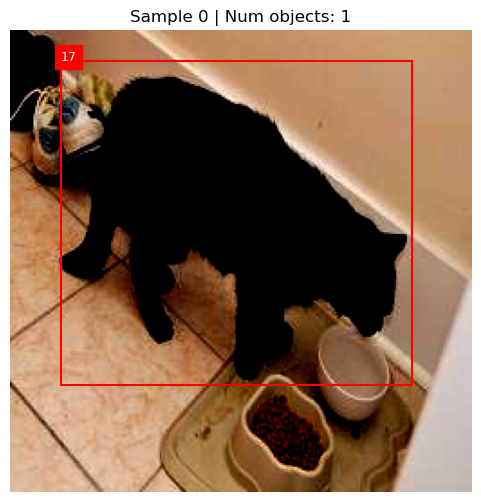

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


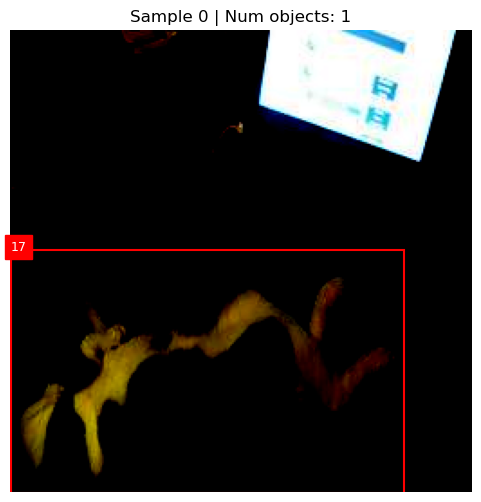

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


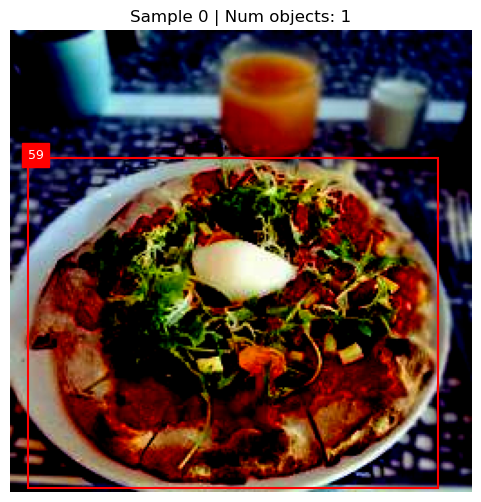

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


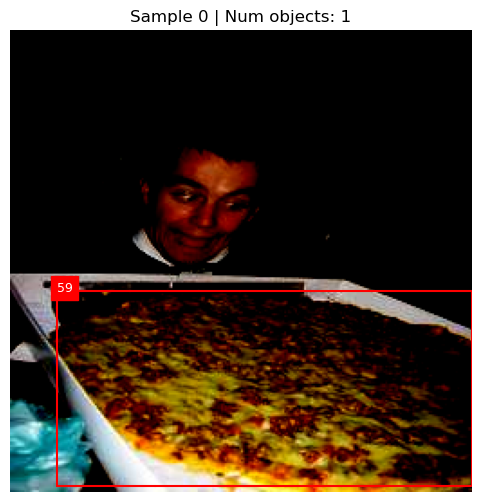

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


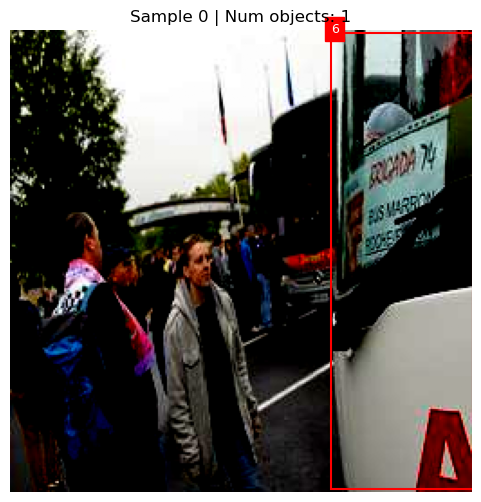

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


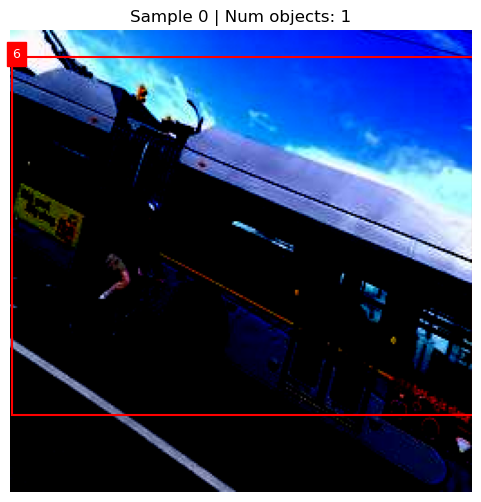

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1]


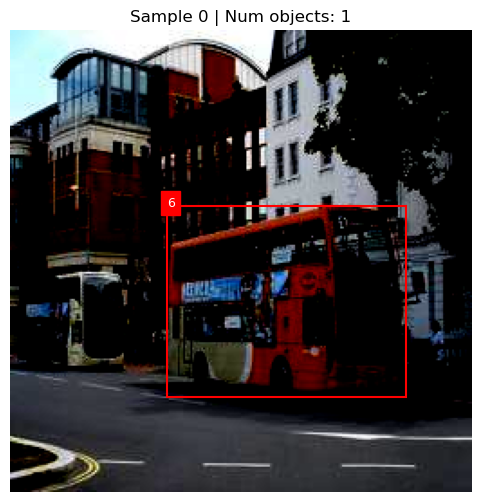

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


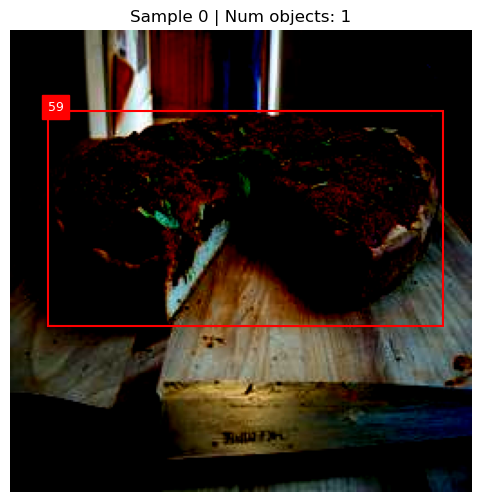

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


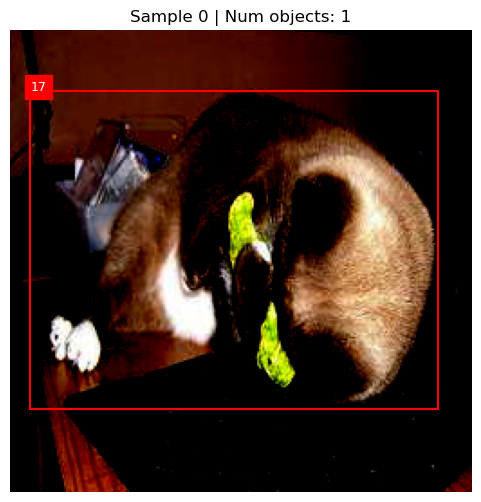

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


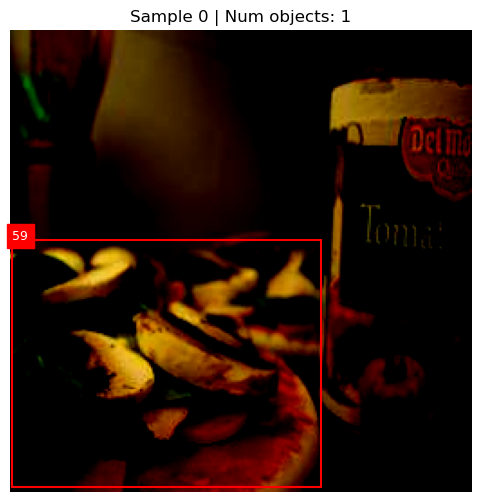

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape: torch.Size([16, 3, 256, 256])
Number of objects in each image: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1]


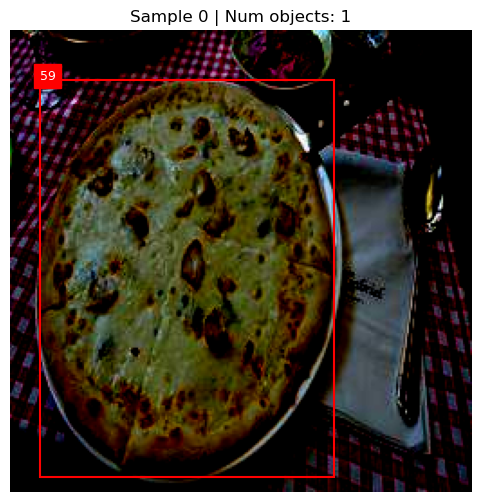

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import torch
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    """
    Custom collate function for handling batches with variable number of bounding boxes.
    Each item in the batch is a tuple:
    (image, seg_mask, bbox_tensor, bbox_label_tensor, num_objects)
    """
    images = torch.stack([item[0] for item in batch], dim=0)
    
    # Keep bbox tensors, labels, and num_objects as lists since they are of variable length.
    bbox_tensors = [item[1] for item in batch]
    bbox_label_tensors = [item[2] for item in batch]
    num_objects = [item[3] for item in batch]
    
    return images, bbox_tensors, bbox_label_tensors, num_objects

# Create your DataLoader with the custom collate function:
train_loader = DataLoader(
    train_dataset,        # your custom dataset instance
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=custom_collate_fn  # use the custom collate function here
)


def show_sample(batch, idx=0):
    """
    Visualize one sample from the batch with its bounding boxes.
    Args:
        batch: tuple of (images, seg_masks, bbox_tensor, bbox_label_tensor, num_objects)
        idx: index of the sample in the batch to visualize.
    """
    images, bbox_tensor, bbox_label_tensor, num_objects = batch
    # Convert the tensor image to numpy array (H, W, C) for matplotlib.
    image = images[idx].permute(1, 2, 0).numpy()
    
    # Create a plot.
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(image)
    
    # Get bounding boxes and labels for the selected image.
    # Note: Each image may have a different number of bounding boxes.
    bboxes = bbox_tensor[idx].numpy()  # Each bbox: [x, y, width, height]
    labels = bbox_label_tensor[idx].numpy()
    
    # Overlay each bounding box on the image.
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        # Create a rectangle patch.
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Add the label as text on the rectangle.
        ax.text(x, y, str(labels[i]), color='white', fontsize=9, backgroundcolor='red')
    
    ax.set_title(f"Sample {idx} | Num objects: {num_objects[idx]}")
    plt.axis('off')
    plt.show()

# Testing the train_loader
# Assuming train_loader is already defined as your DataLoader instance.

test =0
for batch in train_loader:
    # Unpack batch and print tensor shapes
    images, bbox_tensor, bbox_label_tensor, num_objects = batch
    print("Images shape:", images.shape)                  # Expected: [batch_size, 3, 256, 256]
    # print("Bounding boxes tensor shape:", bbox_tensor.shape)        # Expected: [batch_size, N, 4]
    # print("Bounding box labels shape:", bbox_label_tensor.shape)      # Expected: [batch_size, N]
    print("Number of objects in each image:", num_objects)  # Typically a tensor/list of length batch_size
    
    # Visualize the first sample in the batch
    show_sample(batch, idx=0)
    if test == 10:
        break  # Only process one batch for testing
    test+=1


In [ ]:
class NetForYolo(nn.Module):
            """
            Recall that each YOLO vector is of size 5+C where C is the number of classes.  Since C
            equals 3 for the dataset used in the demo code in the Examples directory, our YOLO vectors
            are 8 elements long.  A YOLO tensor is a tensor representation of all the YOLO vectors
            created for a given training image.  The network shown below assumes that the input to
            the network is a flattened form of the YOLO tensor.  With an 8-element YOLO vector, a
            6x6 gridding of an image, and with 5 anchor boxes for each cell of the grid, the 
            flattened version of the YOLO tensor would be of size 1440.

            In Version 2.0.6 of the YOLOLogic module, I introduced a new loss function for this network
            that calls for using nn.CrossEntropyLoss for just the last C elements of each YOLO
            vector. [See Lines 64 through 83 of the code for "run_code_for_training_multi_instance_
            detection()" for how the loss is calculated in 2.0.6.]  Using nn.CrossEntropyLoss 
            required augmenting the last C elements of the YOLO vector with one additional 
            element for the purpose of representing the absence of an object in any given anchor
            box of a cell.  

            With the above mentioned augmentation, the flattened version of a YOLO tensor is
            of size 1620.  That is the reason for the one line change at the end of the 
            constructor initialization code shown below.
            """ 
            def __init__(self, skip_connections=True, depth=8):
                super(YOLOLogic.YoloObjectDetector.NetForYolo, self).__init__()
                if depth not in [8,10,12,14,16]:
                    sys.exit("This network has only been tested for 'depth' values 8, 10, 12, 14, and 16")
                self.depth = depth // 2
                self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
                self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
                self.pool = nn.MaxPool2d(2, 2)
                self.bn1  = nn.BatchNorm2d(64)
                self.bn2  = nn.BatchNorm2d(128)
                self.bn3  = nn.BatchNorm2d(256)
                self.skip64_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64_arr.append(YOLOLogic.YoloObjectDetector.SkipBlock(64, 64,
                                                                                    skip_connections=skip_connections))
                self.skip64ds = YOLOLogic.YoloObjectDetector.SkipBlock(64,64,downsample=True, 
                                                                                     skip_connections=skip_connections)
                self.skip64to128 = YOLOLogic.YoloObjectDetector.SkipBlock(64, 128, 
                                                                                    skip_connections=skip_connections )
                self.skip128_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128_arr.append(YOLOLogic.YoloObjectDetector.SkipBlock(128,128,
                                                                                    skip_connections=skip_connections))
                self.skip128ds = YOLOLogic.YoloObjectDetector.SkipBlock(128,128,
                                                                    downsample=True, skip_connections=skip_connections)
                self.skip128to256 = YOLOLogic.YoloObjectDetector.SkipBlock(128, 256, 
                                                                                    skip_connections=skip_connections )
                self.skip256_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip256_arr.append(YOLOLogic.YoloObjectDetector.SkipBlock(256,256,
                                                                                    skip_connections=skip_connections))
                self.skip256ds = YOLOLogic.YoloObjectDetector.SkipBlock(256,256,
                                                                    downsample=True, skip_connections=skip_connections)
                self.fc_seqn = nn.Sequential(
                    nn.Linear(8192, 4096),
                    nn.ReLU(inplace=True),
                    nn.Linear(4096, 2048),
                    nn.ReLU(inplace=True),
                    nn.Linear(2048, 1620)
                )

            def forward(self, x):
                x = self.pool(torch.nn.functional.relu(self.conv1(x)))          
                x = nn.MaxPool2d(2,2)(torch.nn.functional.relu(self.conv2(x)))       
                for i,skip64 in enumerate(self.skip64_arr[:self.depth//4]):
                    x = skip64(x)                
                x = self.skip64ds(x)
                for i,skip64 in enumerate(self.skip64_arr[self.depth//4:]):
                    x = skip64(x)                
                x = self.bn1(x)
                x = self.skip64to128(x)
                for i,skip128 in enumerate(self.skip128_arr[:self.depth//4]):
                    x = skip128(x)                
                x = self.bn2(x)
                x = self.skip128ds(x)
                x = x.view(-1, 8192 )
                x = self.fc_seqn(x)
                return x

### Building Your Deep Neural Network
- **yolo_vector**

A 1D vector that represents a single bounding box prediction.
[cx, cy, w, h, pc, p1, p2, ... pn]
cx, cy: Center coordinates of the bounding box (normalized).
w, h: Width and height of the bounding box (normalized).
pc: Confidence score (probability that an object exists in the box).
p1, p2, ... pn: Class probabilities (softmax output for each class).
​

- **yolo_tensor**

A multi-dimensional tensor that holds multiple yolo_vectors for a grid of cells.



In [32]:
import os, sys
print(os.getcwd())
sys.path.append("./../YOLOLogic-2.1.4")

from YOLOLogic import *



/scratch/gilbreth/chen4126/ECE60146/HW7


# 2. Dataloader

### 2.1 Code block showing all parameters for yolo vector are generated

### 2.2 explanationg showing all parameters for yolo vector are generated

# 3. Training

### 3.1 Code block showing how yolo tensor is built

### 3.2 explanation of building how yolo tensor is built

### 3.3 BCE, CE, MSE loss curves

# 4. Evaluation

### 4.1 Code block translate yolo tensor to BB pred and class label

### 4.2 Explanation translate yolo tensor to BB pred and class label

### 4.3 24 images

# 5. Bonus IoU loss with DIoU

### 5.1 BCE, CE, DIoU loss curves

### 5.2 24 images